In [40]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2

In [57]:
# Training data
app_train = pd.read_csv('input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

# Testing data features
app_test = pd.read_csv('input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()


Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


   TARGET      nb          %
0       0  282686  91.927118
1       1   24825   8.072882


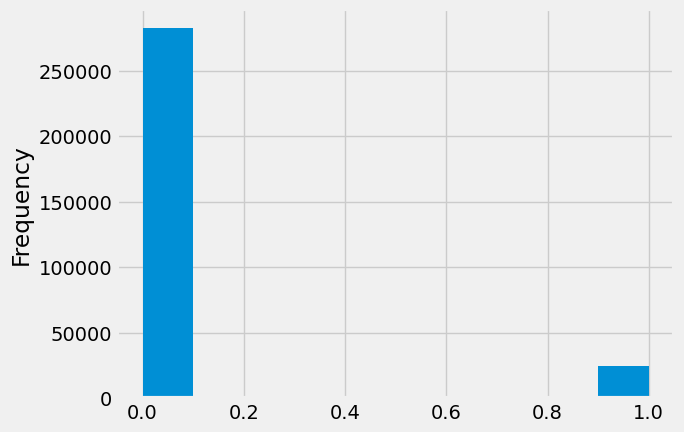

In [42]:
app_train['TARGET'].value_counts()
app_train['TARGET'].astype(int).plot.hist()

target_repartition = app_train.groupby(['TARGET'])['TARGET'].count().reset_index(name='nb')
target_repartition['%'] = 100 * target_repartition['nb'] / target_repartition['nb'].sum()
print(target_repartition)


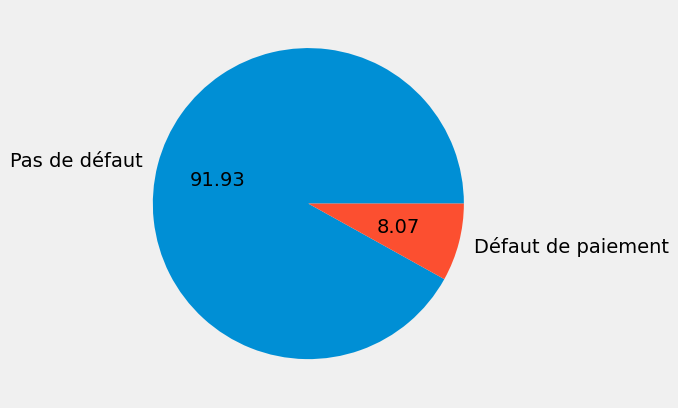

In [43]:
# checking diabetic and non diabetic pepoles average by pie 
labels=["Pas de défaut","Défaut de paiement"]
plt.pie(app_train["TARGET"].value_counts() ,
        labels = labels ,
        autopct='%.02f' );

In [58]:

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

# Number of each type of column
app_train.dtypes.value_counts()

# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [59]:
# class count
class_count_0, class_count_1 = app_train['TARGET'].value_counts()

# Separate class
class_0 = app_train[app_train['TARGET'] == 0]
class_1 = app_train[app_train['TARGET'] == 1]
print('TARGET 0:', class_0.shape)
print('TARGET 1:', class_1.shape)

TARGET 0: (282686, 122)
TARGET 1: (24825, 122)


In [60]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

train_labels = app_train['TARGET']
# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

3 columns were label encoded.
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


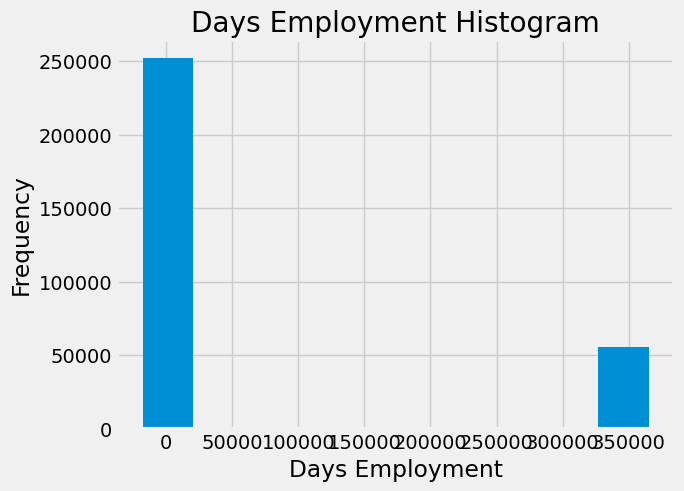

In [61]:
# Anomalies
(app_train['DAYS_BIRTH'] / -365).describe()
app_train['DAYS_EMPLOYED'].describe()

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))


There are 9274 anomalies in the test data out of 48744 entries


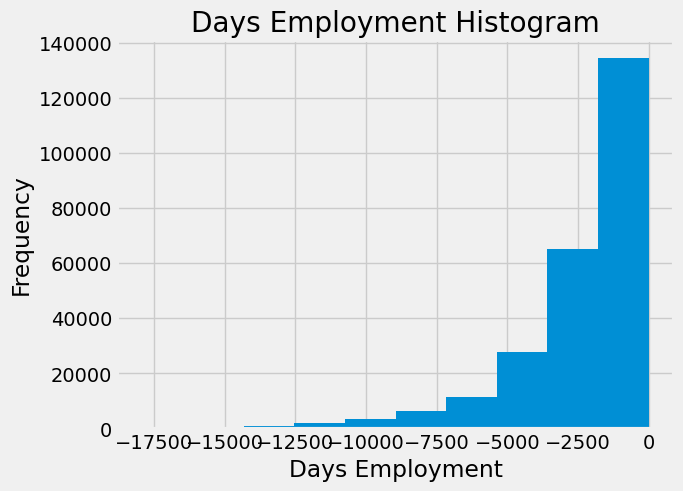

In [62]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

# Create anomalous flag column in app test
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Text(0, 0.5, 'Count')

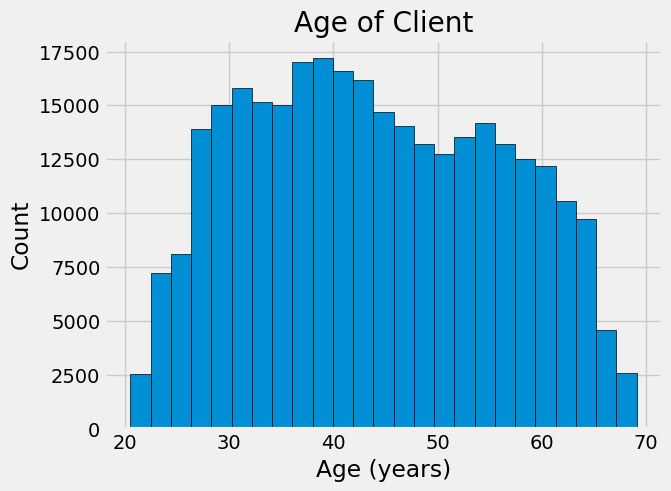

In [63]:
# Pearson Method
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

In [64]:
# Extract the EXT_SOURCE variables and show correlations
cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
        'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE_Higher education',
        'CODE_GENDER_F', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT']
ext_data = app_train[cols]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_F,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239,0.060893,-0.056593,-0.054704,0.074958,0.060893,0.058899
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610,-0.115374,0.135180,0.306729,-0.252712,-0.115374,-0.115341
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996,-0.288299,0.124581,0.014611,-0.093444,-0.288299,-0.292895
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478,-0.012158,-0.022429,0.023066,-0.129722,-0.012158,-0.012903
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000,-0.008073,-0.115808,0.148074,-0.352321,-0.008073,-0.009361
REGION_RATING_CLIENT_W_CITY,0.060893,-0.115374,-0.288299,-0.012158,-0.008073,1.000000,-0.067580,0.017276,-0.009311,1.000000,0.950842
NAME_EDUCATION_TYPE_Higher education,-0.056593,0.135180,0.124581,-0.022429,-0.115808,-0.067580,1.000000,0.016031,0.003662,-0.067580,-0.065014
CODE_GENDER_F,-0.054704,0.306729,0.014611,0.023066,0.148074,0.017276,0.016031,1.000000,-0.092544,0.017276,0.017874
DAYS_EMPLOYED,0.074958,-0.252712,-0.093444,-0.129722,-0.352321,-0.009311,0.003662,-0.092544,1.000000,-0.009311,-0.010755
REGION_RATING_CLIENT_W_CITY,0.060893,-0.115374,-0.288299,-0.012158,-0.008073,1.000000,-0.067580,0.017276,-0.009311,1.000000,0.950842


<Figure size 800x600 with 0 Axes>

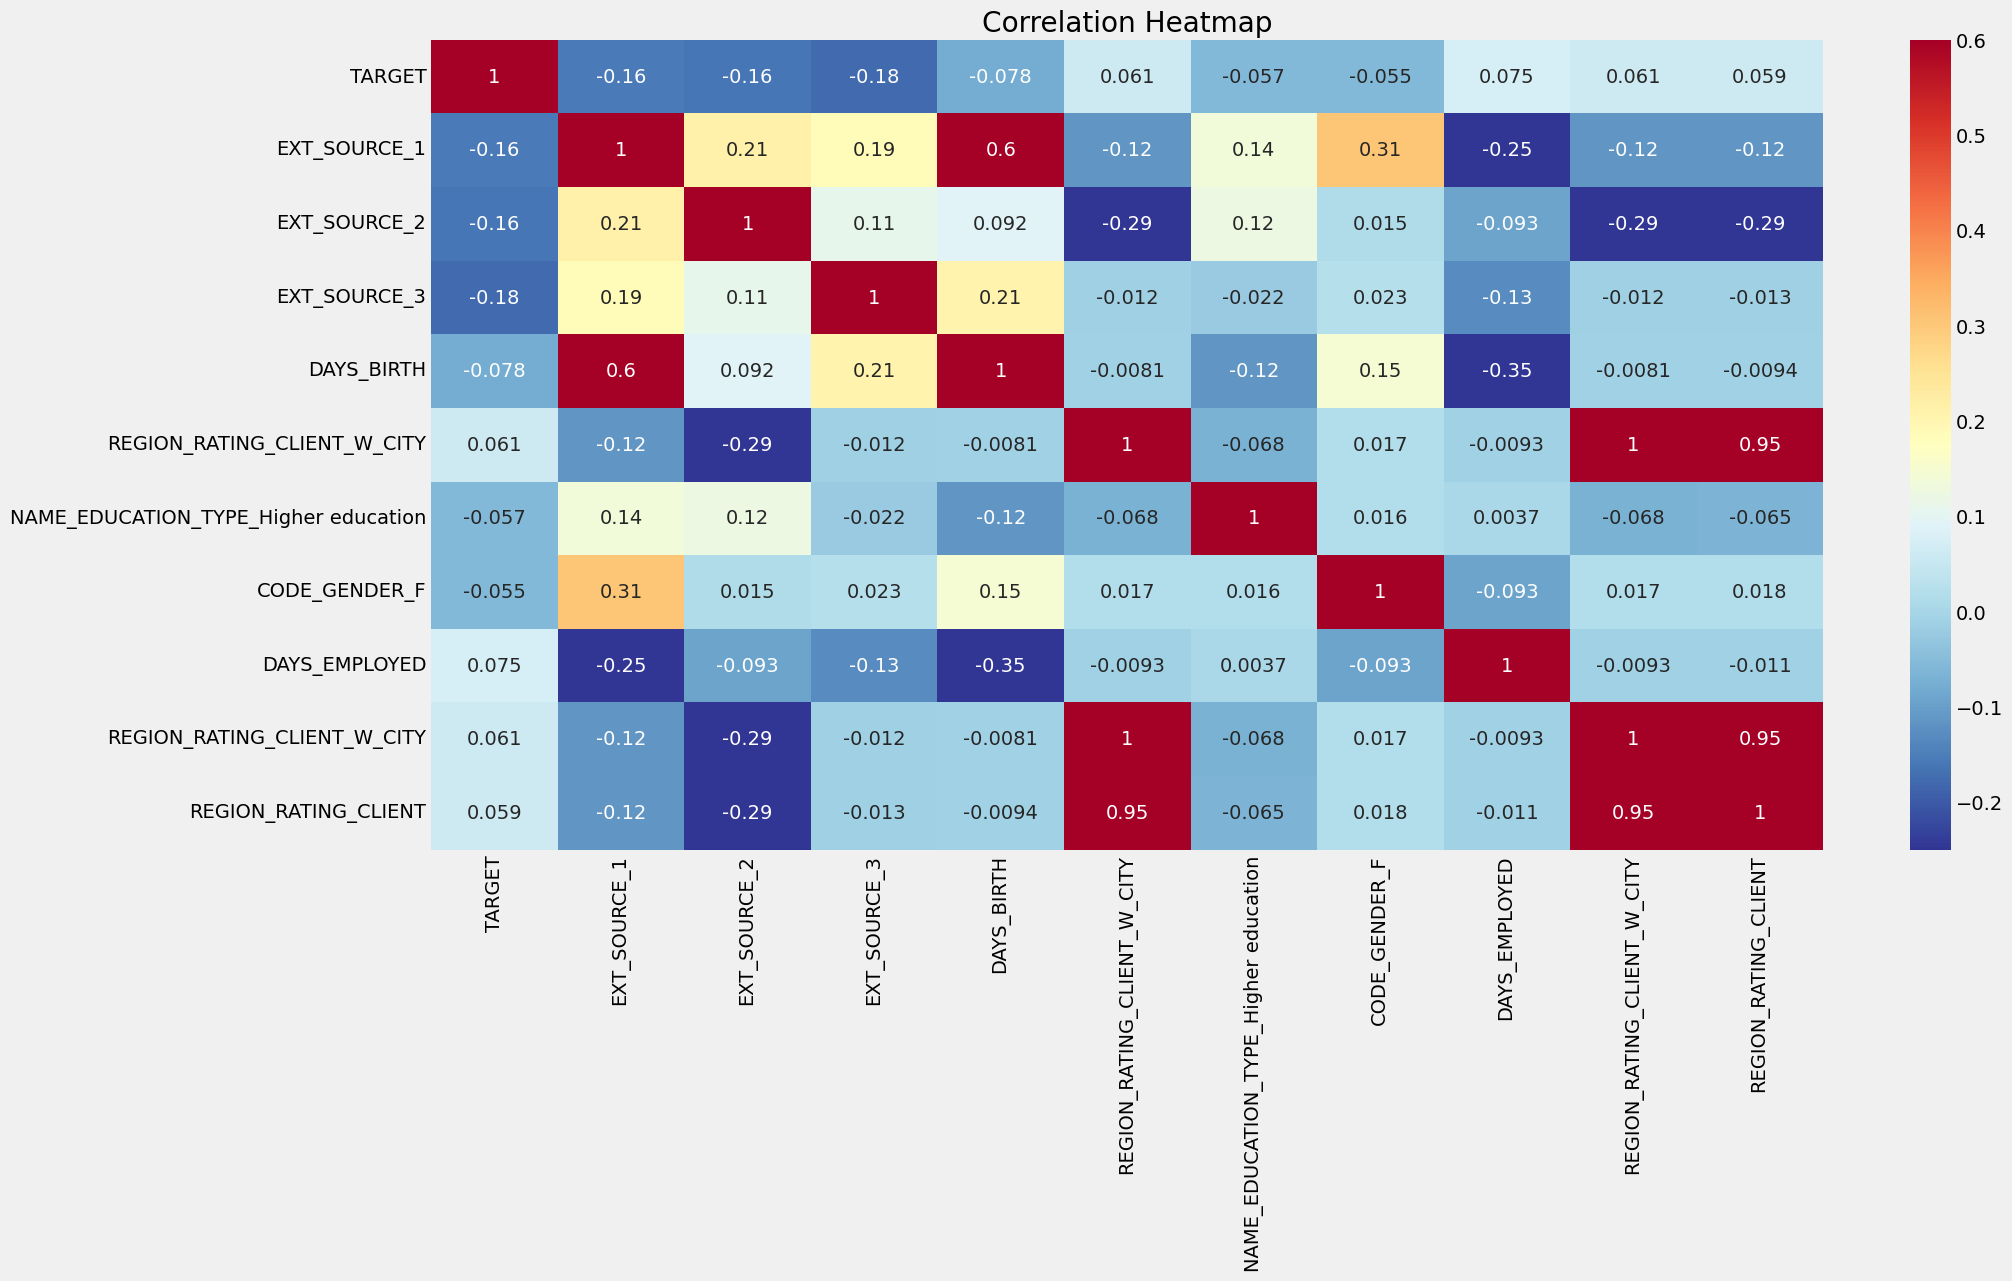

In [65]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
plt.figure(figsize = (20,10))

sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [66]:
ext_data_corrs_spearman = ext_data.corr(method = 'spearman')
ext_data_corrs_spearman

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_F,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT
TARGET,1.000000,-0.151128,-0.147332,-0.166330,-0.078328,0.060936,-0.056593,-0.054704,0.080271,0.060936,0.058909
EXT_SOURCE_1,-0.151128,1.000000,0.220776,0.181127,0.600176,-0.113790,0.133734,0.303611,-0.232744,-0.113790,-0.113242
EXT_SOURCE_2,-0.147332,0.220776,1.000000,0.106182,0.102158,-0.317072,0.131226,0.013950,-0.109754,-0.317072,-0.322716
EXT_SOURCE_3,-0.166330,0.181127,0.106182,1.000000,0.205208,-0.013777,-0.024395,0.021753,-0.135494,-0.013777,-0.015156
DAYS_BIRTH,-0.078328,0.600176,0.102158,0.205208,1.000000,-0.009203,-0.118534,0.146858,-0.307446,-0.009203,-0.010445
REGION_RATING_CLIENT_W_CITY,0.060936,-0.113790,-0.317072,-0.013777,-0.009203,1.000000,-0.066645,0.017136,-0.008649,1.000000,0.950041
NAME_EDUCATION_TYPE_Higher education,-0.056593,0.133734,0.131226,-0.024395,-0.118534,-0.066645,1.000000,0.016031,0.001514,-0.066645,-0.063358
CODE_GENDER_F,-0.054704,0.303611,0.013950,0.021753,0.146858,0.017136,0.016031,1.000000,-0.081551,0.017136,0.017697
DAYS_EMPLOYED,0.080271,-0.232744,-0.109754,-0.135494,-0.307446,-0.008649,0.001514,-0.081551,1.000000,-0.008649,-0.010593
REGION_RATING_CLIENT_W_CITY,0.060936,-0.113790,-0.317072,-0.013777,-0.009203,1.000000,-0.066645,0.017136,-0.008649,1.000000,0.950041


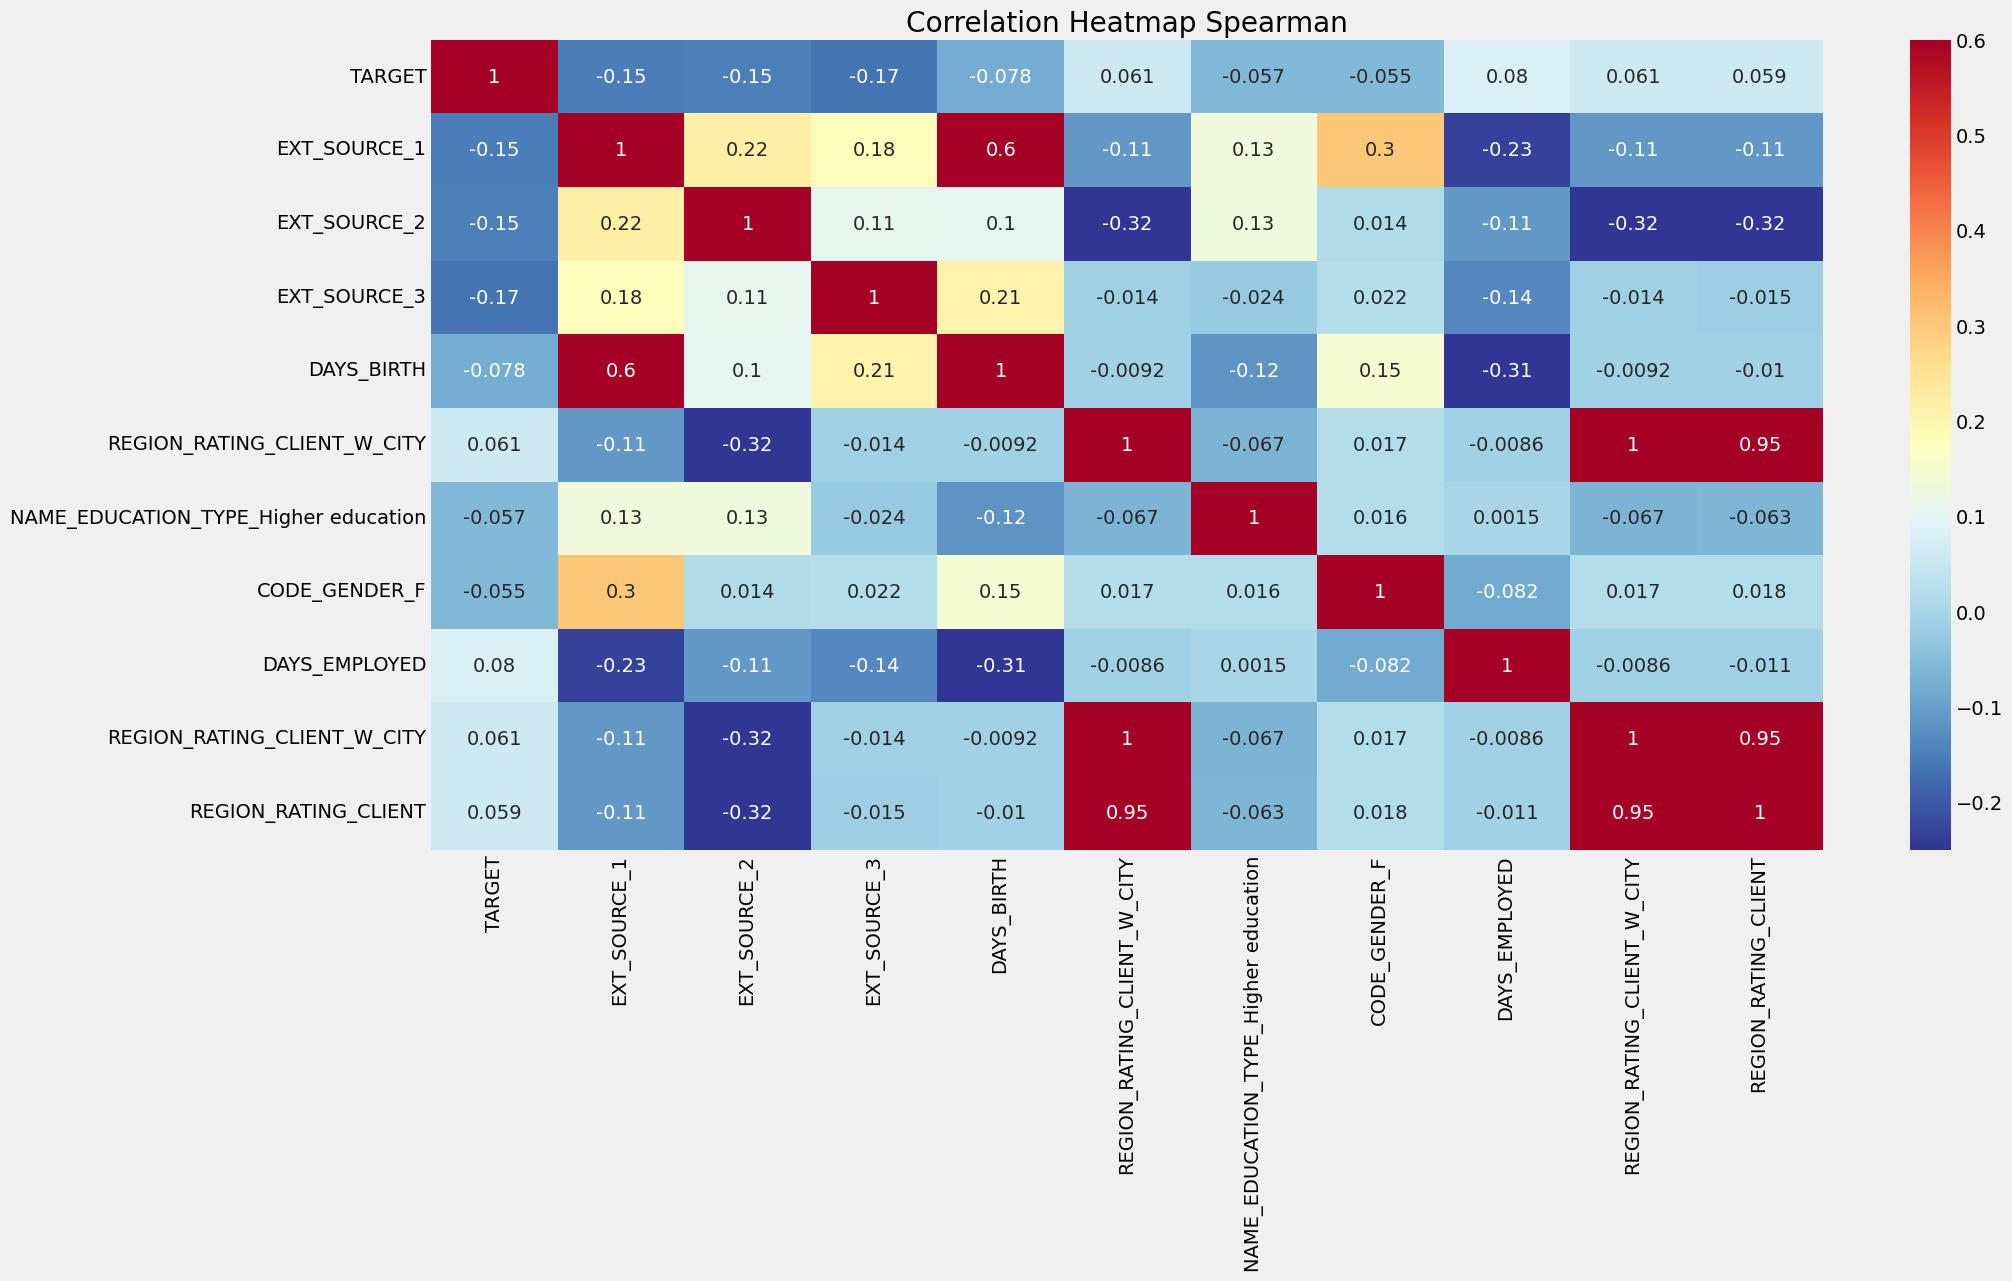

In [ ]:
# Spearman
# Variable qualitative et quantitative
# Check si certaines variables explicatives ne sont pas corrélées entre elles, si oui en sélectionner qu'une par paire
plt.figure(figsize = (20, 10))

# Heatmap of correlations
sns.heatmap(ext_data_corrs_spearman, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap Spearman');

**TEST CORRELATIONS**

In [ ]:
# # Test Chi-2 ------------------------
# table = pd.crosstab(df[''])

# app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY']]
# # chi2_contingency

In [46]:
from preprocessing import preprocessing
df = preprocessing()


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 57s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 109s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 44s
Installments payments df shape: (339587, 26)
Process installments payments - done in 44s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 33s
df shape after preprocessing : (356251, 798)


In [48]:
print(df.columns.tolist())
df


['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
from sklearn.preprocessing import StandardScaler

cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
        'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE_Higher education',
        'CODE_GENDER_F']
data = app_train[cols]
#apply SelectKBest class to extract top 10 best features
BestFeatures = SelectKBest(score_func=chi2, k=10)

# Split data into features and target
X = data.drop('TARGET', axis=1)
Y = data['TARGET']
fit = BestFeatures.fit(X,Y)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

#concatenating two dataframes for better visualization
f_Scores = pd.concat([df_columns,df_scores],axis=1) # feature scores
f_Scores.columns = ['Feature','Score']
f_Scores
print(f_Scores.nlargest(16,'Score'))


                                Feature         Score
3                            DAYS_BIRTH  15725.655479
5  NAME_EDUCATION_TYPE_Higher education     20.411930
2                          EXT_SOURCE_3     19.992924
0                          EXT_SOURCE_1     15.952628
1                          EXT_SOURCE_2     10.786260
4           REGION_RATING_CLIENT_W_CITY      6.601171
6                         CODE_GENDER_F      4.941765
